In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
from deepxde.backend import tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [ ]:
import numpy as np
import random
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt

# Config
lamda = 0.03110
M = 0.2
EPOCHS = 18000
K = 10  # 10-folds
seed_list = list(range(82, 82 + K))

RESIDUALS_LIST = []
RESIDUALS_LIST_cross = []

# Define the PDE
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.5 * dy_xx - (M * 0.5) * y

# Geometry and conditions
geom = dde.geometry.Interval(-2, 2)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

# Cross-validation loop
for i, seed in enumerate(seed_list):
    print(f"\nFold {i+1}/{K} with seed {seed}")
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()

    # Fixed training data
    data = dde.data.TimePDE(
        geomtime, pde, [bc, ic],
        num_domain=2500, num_boundary=700, num_initial=600, num_test=2000
    )

    net = dde.nn.FNN([2] + [30] * 5 + [1], "sin", "Glorot normal")
    model_cross = dde.Model(data, net)
    model_cross.compile("adam", lr=1e-3, loss_weights=(1, 1, lamda))
    model_cross.train(iterations=EPOCHS, display_every=400)

     # Compute residuals at test points
    X_test = data.test_x
    residuals = model_cross.predict(X_test, operator=pde).flatten()
    RESIDUALS_LIST.append(residuals)

    # Unseen test points — regenerated each fold
    np.random.seed(seed + 100)
    X_unseen = geomtime.random_points(1500)

    residual_cross = model_cross.predict(X_unseen, operator=pde).flatten()
    RESIDUALS_LIST_cross.append(residual_cross)





Fold 1/10 with seed 82
Compiling model...
Building feed-forward neural network...
'build' took 0.118152 s

'compile' took 0.947654 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.82e-01, 6.50e-01, 3.03e-02]    [3.42e-01, 6.50e-01, 3.03e-02]    []  
400       [3.45e-05, 4.84e-05, 1.55e-02]    [3.81e-05, 4.84e-05, 1.55e-02]    []  
800       [5.13e-06, 5.35e-05, 1.54e-02]    [5.28e-06, 5.35e-05, 1.54e-02]    []  
1200      [3.16e-06, 6.99e-05, 1.54e-02]    [2.44e-06, 6.99e-05, 1.54e-02]    []  
1600      [5.45e-06, 8.97e-05, 1.54e-02]    [4.52e-06, 8.97e-05, 1.54e-02]    []  
2000      [8.37e-06, 1.06e-04, 1.53e-02]    [6.80e-06, 1.06e-04, 1.53e-02]    []  
2400      [1.28e-05, 1.17e-04, 1.53e-02]    [1.03e-05, 1.17e-04, 1.53e-02]    []  
2800      [1.97e-05, 1.24e-04, 1.53e-02]    [1.59e-05, 1.24e-04, 1.53e-02]    []  
3200      [2.82e-05, 1.27e-04, 1.52e-02]    [2.28e-05, 1.27e-04, 1.52e-02]    []  
3600     


Residual Statistics across 10 seeds:
Mean residual (average across test points): -4.9187e-04
Std deviation of residuals: 5.0306e-03
95% Confidence Interval (mean): ±3.1180e-03


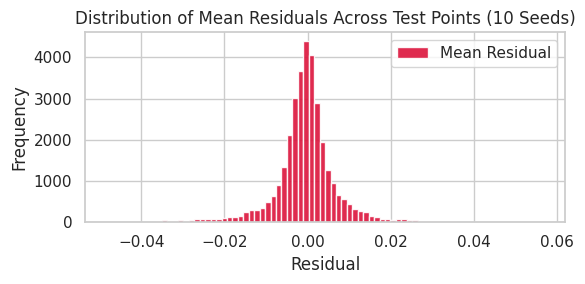

In [ ]:
# Convert list of residuals to numpy array for statistics
residuals_array = np.array(RESIDUALS_LIST)  # Shape: (10, num_test_points)

# Compute statistics
mean_residual = np.mean(residuals_array, axis=0)
std_residual = np.std(residuals_array, axis=0)
conf_interval_95 = 1.96 * std_residual / np.sqrt(len(seed_list))

# Print summary statistics
print("\nResidual Statistics across 10 seeds:")
print(f"Mean residual (average across test points): {np.mean(mean_residual):.4e}")
print(f"Std deviation of residuals: {np.mean(std_residual):.4e}")
print(f"95% Confidence Interval (mean): ±{np.mean(conf_interval_95):.4e}")

# Optionally: save or plot residual distributions
plt.figure(figsize=(6, 3))
plt.hist(residuals_array.flatten(), bins=80, alpha=0.9, color='crimson', label='Mean Residual')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Residuals Across Test Points (10 Seeds)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("residual_histogram.png")
plt.show()



=== Residual Statistics on Unseen Data Across Folds ===
Mean Residual: -3.6481e-04
Std Dev: 7.1627e-03
95% Confidence Interval: ±1.1463e-04


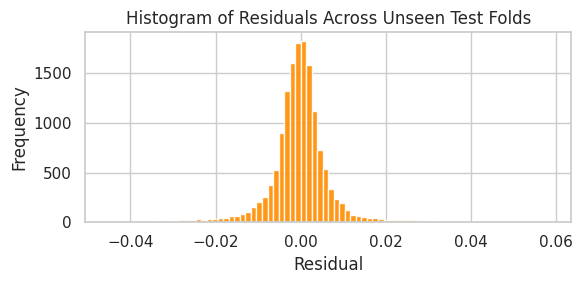

In [ ]:
# === Final Statistics ===
residuals_array_cross = np.array(RESIDUALS_LIST_cross)  # shape (K, 1500)

mean_all = np.mean(residuals_array_cross)
std_all = np.std(residuals_array_cross)
ci_95 = 1.96 * std_all / np.sqrt(residuals_array_cross.size)

print("\n=== Residual Statistics on Unseen Data Across Folds ===")
print(f"Mean Residual: {mean_all:.4e}")
print(f"Std Dev: {std_all:.4e}")
print(f"95% Confidence Interval: ±{ci_95:.4e}")

# Visualization
plt.figure(figsize=(6, 3))
plt.hist(residuals_array_cross.flatten(), bins=80, alpha=0.9, color='darkorange', label='Mean Residual')
plt.title("Histogram of Residuals Across Unseen Test Folds")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("crossval_unseen_residuals.png")
plt.show()